In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [122]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#change this five times to get 5 cross validation
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:0


## 1. ETL

In [123]:
# Use datasets.CIFAR10 to get train and test
# Split train to train and val in the % 80:20

transform  = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [124]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [125]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [126]:
len(train_data)

50000

In [127]:
len(test_data)

10000

In [128]:
50000*0.8

40000.0

In [129]:
train_set, val_set = torch.utils.data.random_split(train_data, [40000, 10000])

## 2. EDA

In [130]:
image = train_set[0][0]
image.shape

torch.Size([3, 32, 32])

In [131]:
image = torch.permute(train_set[0][0], (1,2,0))
image.shape

torch.Size([32, 32, 3])

torch.Size([3, 32, 32])


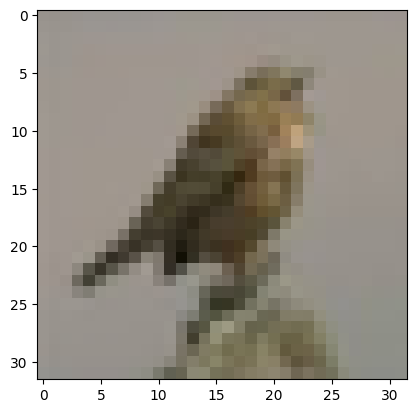

In [132]:
# Print one sample image from training set
print(train_set[0][0].shape)
#Shape C, W, H

plt.imshow(image)

In [133]:
#train_data.targets

In [134]:
#Check num. labels
labels = set(train_data.targets)




In [135]:
#for each label, print one sample image
indeces = []
labels  = []
for index, label in enumerate(train_data.targets):
    if len(indeces) < 10:
        if label not in labels:
           labels.append(label)
           indeces.append(index)
    

In [136]:
labels, indeces

([6, 9, 4, 1, 2, 7, 8, 3, 5, 0], [0, 1, 3, 4, 6, 7, 8, 9, 27, 29])

In [137]:
for index, label in zip(labels, indeces ):
    print(index, label)

6 0
9 1
4 3
1 4
2 6
7 7
8 8
3 9
5 27
0 29


In [138]:
sorted_indices = [label for _, label in sorted(zip(labels, indeces))]

Labels:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


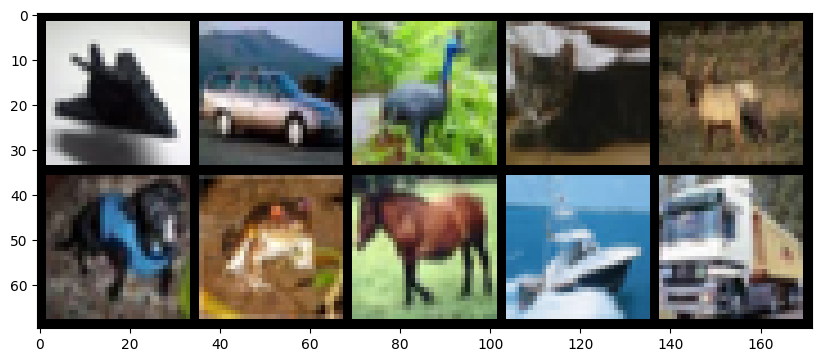

In [139]:
images = []
for i, image_index in enumerate(sorted_indices):  #O(1)
    image = train_data[image_index][0]
    images.append(image)

image_tensor = torch.stack(images, 0)
image_tensor.shape #tensor shape:  B, C, W, H  #(10, 3, 32, 32)

print("Labels: ", torch.arange(10))

grid_image = make_grid(image_tensor, nrow=5)
grid_image = torch.permute(grid_image, (1, 2, 0))
plt.figure(figsize=(10, 8))
plt.imshow(grid_image)

## 3. Create DataLoaders fro train, val and test

In [140]:
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=2, pin_memory=True )
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### 3.1 Test the dataloaders

In [150]:
#Shape of image

#Sahpe of labes

for image, label in train_loader:
    print(images.shape)
    print(label.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


## 4. Test your knowledge on conv2d

In [151]:
image.shape

torch.Size([100, 3, 32, 32])

In [152]:
#create two layers of conv2d
#from 3 -> 256 -> 128
#image shape:  (B, 3, 32, 32)
#nn.Conv2d(in_c, out_c, k, s, p)
#out_size = image_size - k + 2p/s +1
layer1 = nn.Conv2d(3, 256, 3, 1, 0)
out    = layer1(image)
print(out.shape)
#out_size = 32 - 3 / 1 + 1
#after layer1 shape:  (B, 256, 30, 30)
layer2 = nn.Conv2d(256, 128, 3, 1, 0)
out    = layer2(out)
print(out.shape)
#out_size = 30 - 3 / 1 + 1
#after layer2 shape: (B, 128, 28, 28)

#don't forget to reshape (B, 128, 28, 28) ==> (B, 128 * 28 * 28)
out = out.reshape(-1, 128*28*28)

#follow by two linear layers of 128 -> 20 -> 10
layer3 = nn.Linear(128*28*28, 20)
out = layer3(out)
print(out.shape)
#after layer3 shape: (B, 20)
layer4 = nn.Linear(20, 10)
out = layer4(out)
print(out.shape)
#after layer4 shape: (B, 10)

torch.Size([100, 256, 30, 30])
torch.Size([100, 128, 28, 28])
torch.Size([100, 20])
torch.Size([100, 10])


In [153]:
# O = (W - F  + 2P)/S + 1
((32 - 3 + 2*0 )/ 1) +1
((30 - 3 + 2*0 )/ 1) +1

28.0

## 5. Design a Neural Network

In [154]:
#device = torch.device('cpu')

In [155]:
class CifarCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        #conv2d (3, 256) -> relu -> batchnorm
        self.conv1 = nn.Conv2d(3, 256, 3, 1, 0)
        self.relu  = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(256)
        
        #conv2d (256, 128) -> relu -> batchnorm
        self.conv2 = nn.Conv2d(256, 128, 3, 1, 0)
        self.norm2 = nn.BatchNorm2d(128)
        
        #linear (128, 64) -> relu -> linear (64, 20) -> relu -> linear (20, 10)
        self.linear1 = nn.Linear(128*28*28, 64)
        self.linear2 = nn.Linear(64, 20)
        self.linear3 = nn.Linear(20, 10)
        
    def forward(self, image):
        out = self.norm1(self.relu(self.conv1(image)))
        out = self.norm2(self.relu(self.conv2(out)))
        out = out.reshape(-1, 128*28*28)
        out = self.relu(self.linear1(out))
        out = self.relu(self.linear2(out))
        
        return self.linear3(out)

## 6. Test the model

In [156]:
# Create the model, put them into the device
model = CifarCNN().to(device)
#model = CifarCNN()

#Let's use image (B, C, W, H)
# random_image = torch.rand((1, 3, 32, 32)).to(device)
# out = model(random_image)
# print(out.shape)
image.shape
image = image.to(device)

# Try input this image
out = model(image)

# Check the output size
out.shape

torch.Size([100, 10])

In [157]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [158]:
count_parameters(model)

  6912
   256
   256
   256
294912
   128
   128
   128
6422528
    64
  1280
    20
   200
    10
______
6727078


In [159]:
3 * 256 * 3 * 3

6912

## 8. Training

In [160]:
#define loss

#define optimizer

#for epochs = 5
    #for trainloader
        #put image and label to device
        
        #1. predict
        #2. loss
        #3. clear gradients
        #4. backpropagate
        #5. update
        
        #print the loss

#define loss
criterion = nn.CrossEntropyLoss()
#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#how do we know 0.001 is good?

num_epoch = 5
val_old_loss = float("Inf")
filepath = "cifarnn.pt"
for e in range(num_epoch):
    total_train_corr = 0
    for batch, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        
        yhat  = model(image)           #1. predict  yhat shape(100, 10)
        loss  = criterion(yhat, label) #2. loss
        
        #add accuracy
        predicted  = torch.max(yhat, 1)[1]
        batch_train_corr = (predicted == label).sum()
        total_train_corr += batch_train_corr
        acc = (total_train_corr * 100) / ((batch_size) * (batch + 1))
        if val_loss < val_old_loss:
                torch.save(model.state_dict(), filepath) #state_dict is simply the weights
                val_old_loss = val_loss


        optimizer.zero_grad()#3. clear gradients
        loss.backward() #4. backpropagate
        optimizer.step() #5. update
        
        if (batch + 1) % 100 == 0:
            # sys.stdout.write(f"\rBatch: {batch+1} - Loss: {loss}")
            print(f"Epoch: {e} - Batch: {batch+1:3f} - Loss: {loss:.2f} - Acc: {acc:.2f}")

    #after each epoch, calculate the validation acc and loss
    with torch.no_grad():
        total_val_corr = 0
        for (val_image, val_label) in val_loader:
            val_image = val_image.to(device)
            val_label = val_label.to(device)
            val_yhat = model(val_image)
            val_loss = criterion(val_yhat, val_label)
            #Save the model with lowerst validation loss
            val_predicted = torch.max(val_yhat, 1)[1]
            total_val_corr += (val_predicted == val_label).sum()
        val_acc = (total_val_corr * 100) / len(val_set)
        print(f"++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}")





Epoch: 0 - Batch: 100.000000 - Loss: 1.95 - Acc: 29.25
Epoch: 0 - Batch: 200.000000 - Loss: 1.52 - Acc: 36.06
Epoch: 0 - Batch: 300.000000 - Loss: 1.47 - Acc: 40.03
Epoch: 0 - Batch: 400.000000 - Loss: 1.40 - Acc: 43.29
++++++Validation++++++  Loss: 1.17 - Acc: 54.74
Epoch: 1 - Batch: 100.000000 - Loss: 1.01 - Acc: 59.99


KeyboardInterrupt: 